In [4]:
# -----------------------------
# PART 1: Colab setup & installs
# -----------------------------
!pip install --quiet timm


from google.colab import drive
drive.mount('/content/drive')


import torch, torchvision, timm
print("Torch:", torch.__version__)
print("Torchvision:", torchvision.__version__)
print("timm:", timm.__version__)
print("CUDA available:", torch.cuda.is_available(), "Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

Mounted at /content/drive
Torch: 2.8.0+cu126
Torchvision: 0.23.0+cu126
timm: 1.0.21
CUDA available: True Device: Tesla T4


In [5]:
# -----------------------------
# PART 2: Data loading and transforms (IMG_SIZE=384)
# -----------------------------
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# ===== USER CONFIG =====
DATA_DIR = "/content/drive/MyDrive/BTC"
TRAIN_DIR = os.path.join(DATA_DIR, "Training")
VAL_DIR   = os.path.join(DATA_DIR, "Validating")
TEST_DIR  = os.path.join(DATA_DIR, "Testing")

IMG_SIZE = 384
BATCH_SIZE = 16
NUM_WORKERS = 4

# ✅ Strong, medically-safe augmentation for Swin
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(
        IMG_SIZE,
        scale=(0.85, 1.0),
        ratio=(0.9, 1.1)
    ),

    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),

    transforms.RandomAffine(
        degrees=10,
        translate=(0.04, 0.04),
        scale=(0.97, 1.03)
    ),

    transforms.ColorJitter(brightness=0.05, contrast=0.05),

    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

# ✅ Datasets and loaders
train_ds = ImageFolder(TRAIN_DIR, transform=train_transforms)
val_ds   = ImageFolder(VAL_DIR,   transform=val_transforms)

print("Classes (train):", train_ds.classes)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)

val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Train size:", len(train_ds), "Val size:", len(val_ds))


Classes (train): ['glioma', 'meningioma', 'notumor', 'pituitary']
Train size: 5712 Val size: 1311


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [6]:
# -----------------------------
# PART 3: Model creation, loss, optimizer, scheduler, helpers
# -----------------------------
import timm
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast

# ===== CONFIG =====
MODEL_NAME    = "swin_base_patch4_window12_384"
NUM_CLASSES   = len(train_ds.classes)
PRETRAINED    = True
LR            = 1e-4
WEIGHT_DECAY  = 1e-2
EPOCHS        = 25
DEVICE        = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = "/content/drive/MyDrive/swin_full_retrain_checkpoint.pth"
# ==================

# ✅ Build model
model = timm.create_model(
    MODEL_NAME,
    pretrained=PRETRAINED,
    num_classes=NUM_CLASSES
).to(DEVICE)

# ✅ Trainable parameter counter
def count_params(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print("Model:", MODEL_NAME)
print("Total params:", sum(p.numel() for p in model.parameters()))
print("Trainable params:", count_params(model))

# ✅ CLASS WEIGHTS (computed using dataset counts)
# glioma = 1321, meningioma = 1339, notumor = 1595, pituitary = 1457
class_weights = torch.tensor([
    1.08,  # glioma
    1.07,  # meningioma
    0.89,  # notumor
    0.98   # pituitary
]).to(DEVICE)

# ✅ Loss with label smoothing (recommended for Swin)
criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=0.05
)

# ✅ Optimizer: AdamW
optimizer = AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

# ✅ Scheduler: cosine decay
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)

# ✅ Mixed precision training
scaler = GradScaler()

# -----------------------------------
# CHECKPOINT HELPERS
# -----------------------------------
def save_checkpoint(state, path=CHECKPOINT_PATH):
    torch.save(state, path)
    print(f"✅ Checkpoint saved to {path}")

def load_checkpoint(path):
    checkpoint = torch.load(path, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['opt_state'])
    scheduler.load_state_dict(checkpoint['sched_state'])
    start_epoch = checkpoint.get('epoch', 0)
    print(f"✅ Loaded checkpoint from epoch {start_epoch}")
    return start_epoch

# -----------------------------------
# VALIDATION FUNCTION
# -----------------------------------
def validate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += images.size(0)

    avg_loss = running_loss / total
    avg_acc  = correct / total
    return avg_loss, avg_acc


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/365M [00:00<?, ?B/s]

Model: swin_base_patch4_window12_384
Total params: 86882684
Trainable params: 86882684


/tmp/ipython-input-412177566.py:65: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [7]:
# -----------------------------
# PART 4: Training loop + checkpoint + evaluation
# -----------------------------
from tqdm import tqdm
import torch.nn.functional as F

best_val_acc = 0.0
start_epoch = 0

# ✅ Freeze backbone (train head only for stability)
for name, param in model.named_parameters():
    if "head" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

print("✅ Backbone frozen. Training head-only for first 5 epochs...")

for epoch in range(start_epoch, EPOCHS):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}", leave=False)
    for images, labels in pbar:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        optimizer.zero_grad()

        # ✅ Mixed precision forward
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        # ✅ Backprop
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_ds)

    # ✅ Update LR scheduler
    scheduler.step()

    # ✅ Validation
    val_loss, val_acc = validate(model, val_loader, DEVICE)
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {epoch_loss:.4f} | "
          f"Val Loss: {val_loss:.4f} | "
          f"Val Acc: {val_acc:.4f}")

    # ✅ Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_checkpoint({
            'epoch': epoch+1,
            'model_state': model.state_dict(),
            'opt_state': optimizer.state_dict(),
            'sched_state': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'classes': train_ds.classes
        }, CHECKPOINT_PATH)

        print("✅ Best model updated!")

    # ✅ Unfreeze all layers at epoch 5
    if epoch + 1 == 5:
        print("🔓 Unfreezing all layers for full fine-tuning...")

        for param in model.parameters():
            param.requires_grad = True

        # Recreate optimizer & scheduler for full fine-tuning
        optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=EPOCHS - 5
        )

print(f"\n✅ Training Completed. Best Validation Accuracy: {best_val_acc:.4f}\n")

# -----------------------------
# OPTIONAL: Evaluate Test Folder
# -----------------------------
from PIL import Image

def evaluate_folder(test_dir):
    y_true, y_pred = [], []

    for cls in sorted(os.listdir(test_dir)):
        cls_path = os.path.join(test_dir, cls)
        if not os.path.isdir(cls_path):
            continue

        for f in os.listdir(cls_path):
            if f.lower().endswith(('.jpg', '.png', '.jpeg')):
                img_path = os.path.join(cls_path, f)
                img = Image.open(img_path).convert("RGB")

                x = val_transforms(img).unsqueeze(0).to(DEVICE)
                with torch.no_grad():
                    logits = model(x)
                    pred = logits.argmax(dim=1).item()

                y_true.append(cls)
                y_pred.append(train_ds.classes[pred])

    # Print per-class accuracy
    labels = sorted(list(set(y_true)))
    stats = {l: {'ok': 0, 'tot': 0} for l in labels}

    for true, pred in zip(y_true, y_pred):
        stats[true]['tot'] += 1
        if true == pred:
            stats[true]['ok'] += 1

    print("\n📊 Test Set Per-Class Accuracy:")
    for cls in labels:
        ok = stats[cls]['ok']
        tot = stats[cls]['tot']
        print(f"{cls}: {ok}/{tot}  ({ok/tot:.3f})")

# To run:
# evaluate_folder(TEST_DIR)


✅ Backbone frozen. Training head-only for first 5 epochs...


Epoch 1/25:   0%|          | 0/357 [00:00<?, ?it/s]/tmp/ipython-input-2599500216.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/25 | Train Loss: 0.3996 | Val Loss: 0.2967 | Val Acc: 0.9641
✅ Checkpoint saved to /content/drive/MyDrive/swin_full_retrain_checkpoint.pth
✅ Best model updated!


Epoch 2/25 | Train Loss: 0.2785 | Val Loss: 0.2471 | Val Acc: 0.9840
✅ Checkpoint saved to /content/drive/MyDrive/swin_full_retrain_checkpoint.pth
✅ Best model updated!


Epoch 3/25 | Train Loss: 0.2497 | Val Loss: 0.2519 | Val Acc: 0.9847
✅ Checkpoint saved to /content/drive/MyDrive/swin_full_retrain_checkpoint.pth
✅ Best model updated!


Epoch 4/25 | Train Loss: 0.2418 | Val Loss: 0.2360 | Val Acc: 0.9901
✅ Checkpoint saved to /content/drive/MyDrive/swin_full_retrain_checkpoint.pth
✅ Best model updated!


Epoch 5/25 | Train Loss: 0.2455 | Val Loss: 0.2510 | Val Acc: 0.9817
🔓 Unfreezing all layers for full fine-tuning...


Epoch 6/25 | Train Loss: 0.2901 | Val Loss: 0.2927 | Val Acc: 0.9687


Epoch 7/25 | Train Loss: 0.2730 | Val Loss: 0.2504 | Val Acc: 0.9802


Epoch 8/25 | Train Loss: 0.2480 | Val Loss: 0.2314 | Val Acc: 0.9901


Epoch 9/25 | Train Loss: 0.2408 | Val Loss: 0.2976 | Val Acc: 0.9626


Epoch 10/25 | Train Loss: 0.2562 | Val Loss: 0.2382 | Val Acc: 0.9893


Epoch 11/25 | Train Loss: 0.2271 | Val Loss: 0.2170 | Val Acc: 0.9954
✅ Checkpoint saved to /content/drive/MyDrive/swin_full_retrain_checkpoint.pth
✅ Best model updated!


Epoch 12/25 | Train Loss: 0.2289 | Val Loss: 0.2368 | Val Acc: 0.9870


Epoch 13/25 | Train Loss: 0.2224 | Val Loss: 0.2302 | Val Acc: 0.9901


Epoch 14/25 | Train Loss: 0.2305 | Val Loss: 0.2252 | Val Acc: 0.9931


Epoch 15/25 | Train Loss: 0.2103 | Val Loss: 0.2224 | Val Acc: 0.9931


Epoch 16/25 | Train Loss: 0.2120 | Val Loss: 0.2245 | Val Acc: 0.9947


Epoch 17/25 | Train Loss: 0.2098 | Val Loss: 0.2231 | Val Acc: 0.9931


Epoch 18/25 | Train Loss: 0.2117 | Val Loss: 0.2216 | Val Acc: 0.9939


Epoch 19/25 | Train Loss: 0.2098 | Val Loss: 0.2221 | Val Acc: 0.9947


Epoch 20/25 | Train Loss: 0.2077 | Val Loss: 0.2224 | Val Acc: 0.9939


Epoch 21/25 | Train Loss: 0.2070 | Val Loss: 0.2133 | Val Acc: 0.9969
✅ Checkpoint saved to /content/drive/MyDrive/swin_full_retrain_checkpoint.pth
✅ Best model updated!


Epoch 22/25 | Train Loss: 0.2059 | Val Loss: 0.2141 | Val Acc: 0.9969


Epoch 23/25 | Train Loss: 0.2048 | Val Loss: 0.2137 | Val Acc: 0.9969


Epoch 24/25 | Train Loss: 0.2041 | Val Loss: 0.2134 | Val Acc: 0.9977
✅ Checkpoint saved to /content/drive/MyDrive/swin_full_retrain_checkpoint.pth
✅ Best model updated!


Epoch 25/25 | Train Loss: 0.2039 | Val Loss: 0.2134 | Val Acc: 0.9977

✅ Training Completed. Best Validation Accuracy: 0.9977



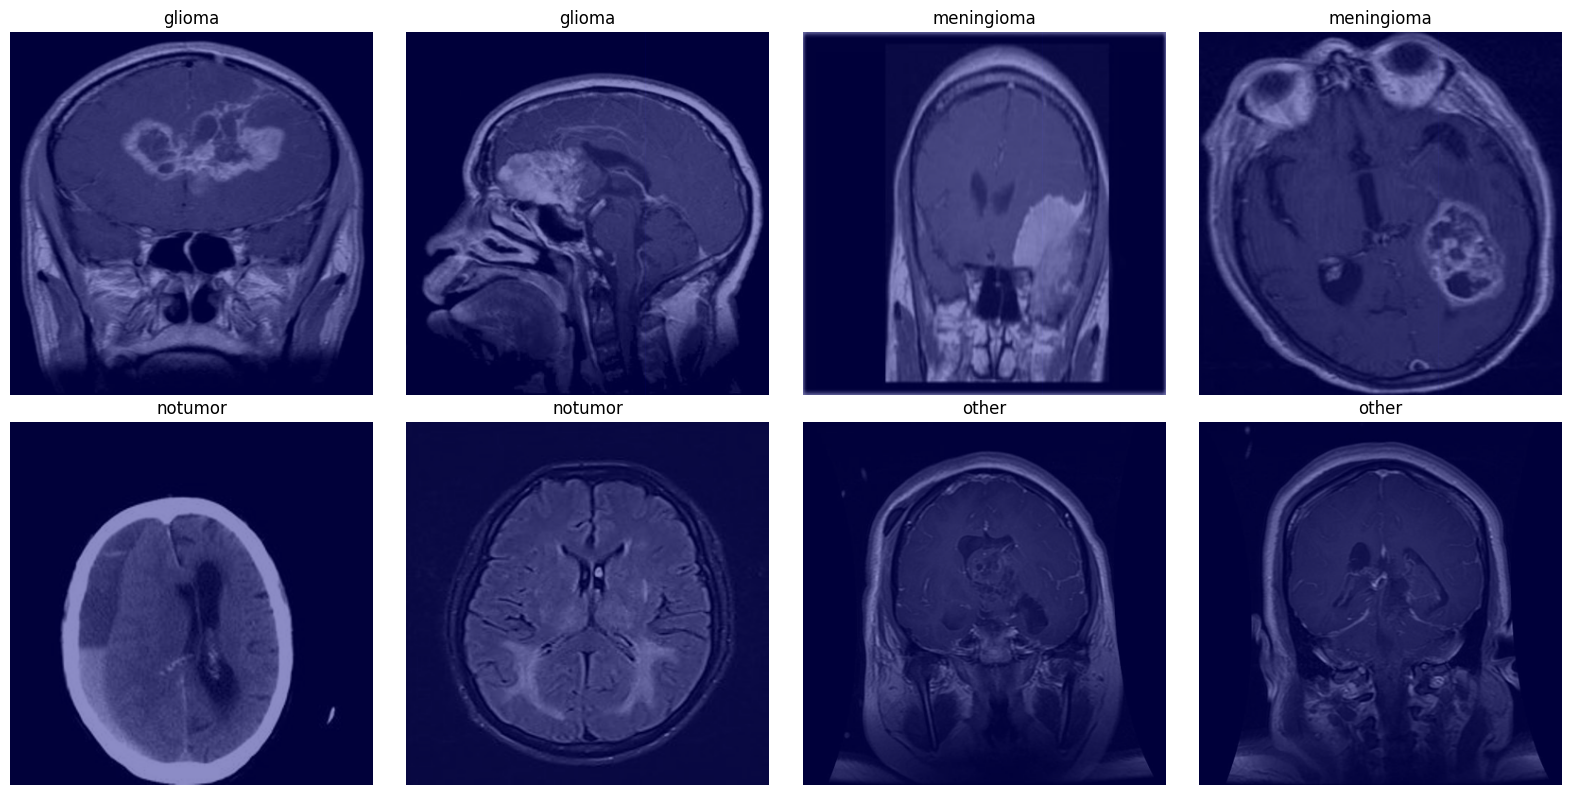

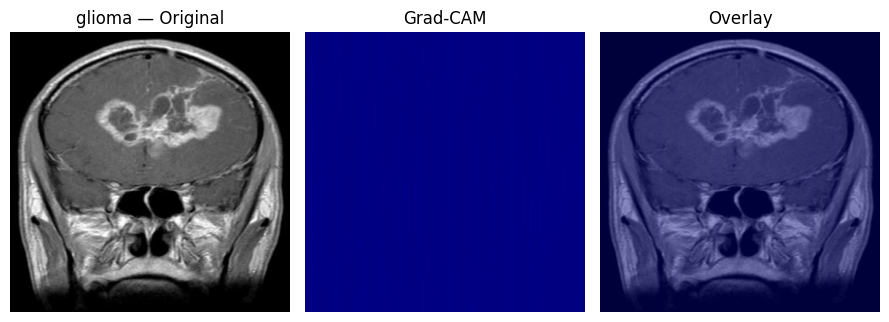

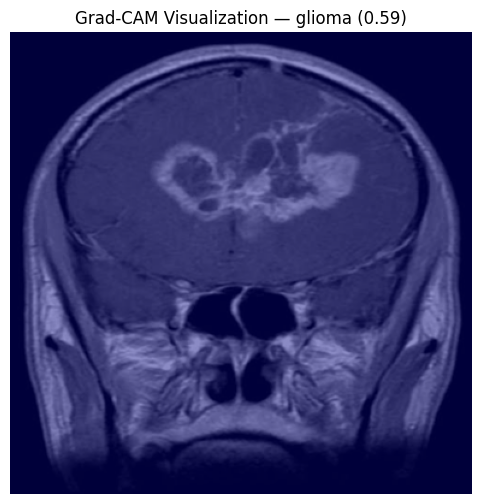

In [11]:
# -----------------------------
# PART 5: Grad-CAM (Grad-CAM + Grad-CAM++) — 3 Styles (A, B, C)
# -----------------------------
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F

# Config (uses variables from earlier parts)
# model, DEVICE, val_transforms, IMG_SIZE, train_ds must already exist

# -----------------------------
# Utility: pick a reasonable target module for Swin
# -----------------------------
def _find_swin_target_module(m):
    # common timm swin internals: model.layers is present
    if hasattr(m, "layers") and len(getattr(m, "layers")) > 0:
        return m.layers[-1]    # final stage
    # some variants: m.blocks
    if hasattr(m, "blocks") and len(getattr(m, "blocks")) > 0:
        return m.blocks[-1]
    # fallback: discover a conv-like module near the end
    mods = [module for module in m.modules()]
    # pick the last module that has parameters
    for mod in reversed(mods):
        if sum(p.numel() for p in mod.parameters()) > 0:
            return mod
    return mods[-1]

default_target_module = _find_swin_target_module(model)

# -----------------------------
# Activation reshape helper (handles patch outputs)
# -----------------------------
def activation_to_bchw(act):
    # act: torch tensor (B, C, H, W) or (B, N, C) or (B, H*W) etc
    a = act.detach().cpu()
    if a.ndim == 4:
        return a  # already B,C,H,W
    if a.ndim == 3:
        B, N, C = a.shape
        # try (B, N, C) -> (B, C, side, side)
        side = int(math.sqrt(N))
        if side * side == N:
            return a.permute(0, 2, 1).reshape(B, C, side, side)
        # try (B, H, W) treat H as channel?
        side = int(math.sqrt(C))
        if side * side == C:
            return a.reshape(B, N, side, side)
    # fallback: attempt flatten reshape
    B = a.shape[0]
    rest = int(np.prod(a.shape[1:]))
    side = int(math.sqrt(rest))
    if side * side == rest:
        return a.reshape(B, 1, side, side)
    raise RuntimeError(f"Unsupported activation shape {tuple(a.shape)} for Grad-CAM")

# -----------------------------
# GradCAM class (supports gradcam + gradcam++)
# -----------------------------
class GradCAM:
    def __init__(self, model, target_module=None, device=None):
        self.model = model
        self.device = DEVICE if device is None else device
        self.activations = None
        self.hook_handles = []
        self.target_module = default_target_module if target_module is None else target_module
        self._register_hooks(self.target_module)

    def _forward_hook(self, module, input, output):
        self.activations = output
        if isinstance(self.activations, torch.Tensor) and not self.activations.requires_grad:
            self.activations.requires_grad_(True)

    def _register_hooks(self, target_module):
        if target_module is None:
            return
        handle = target_module.register_forward_hook(self._forward_hook)
        self.hook_handles.append(handle)

    def remove_hooks(self):
        for h in self.hook_handles:
            try:
                h.remove()
            except Exception:
                pass
        self.hook_handles = []

    def generate(self, input_tensor, class_idx=None, method='gradcam'):
        self.model.zero_grad()
        self.activations = None

        input_tensor = input_tensor.to(self.device)
        logits = self.model(input_tensor)
        probs = F.softmax(logits, dim=1)
        if class_idx is None:
            class_idx = int(probs.argmax(dim=1).item())
        score = logits[0, class_idx]

        # Ensure activations captured
        if self.activations is None:
            _ = self.model(input_tensor)
            if self.activations is None:
                raise RuntimeError("Activations were not captured. Check target module.")

        act = self.activations
        grads_holder = {}
        def save_grad(grad):
            grads_holder['grad'] = grad

        if isinstance(act, (tuple, list)):
            act = act[-1]

        act.register_hook(save_grad)
        score.backward(retain_graph=True)

        grads = grads_holder.get('grad', None)
        if grads is None:
            raise RuntimeError("No gradients captured for Grad-CAM.")

        act_bchw = activation_to_bchw(act)       # torch tensor
        grads_bchw = activation_to_bchw(grads)   # torch tensor

        act_np = act_bchw.cpu().numpy()[0]     # C,H,W
        grads_np = grads_bchw.cpu().numpy()[0] # C,H,W

        if method.lower() == 'gradcam':
            weights = np.mean(grads_np, axis=(1,2))            # C
            cam = np.sum(act_np * weights[:, None, None], axis=0)
        elif method.lower() == 'gradcam++':
            grads2 = grads_np ** 2
            grads3 = grads_np ** 3
            eps = 1e-8
            alpha_num = grads2
            alpha_den = 2.0 * grads2 + act_np * grads3
            alpha_den = np.where(alpha_den != 0.0, alpha_den, eps)
            alpha = alpha_num / alpha_den
            weights = np.sum(alpha * np.maximum(grads_np, 0.0), axis=(1,2))
            cam = np.sum(act_np * weights[:, None, None], axis=0)
        else:
            raise ValueError("method must be 'gradcam' or 'gradcam++'")

        cam = np.maximum(cam, 0)
        if np.max(cam) > 0:
            cam = cam / (np.max(cam) + 1e-8)
        cam_resized = cv2.resize(cam, (input_tensor.shape[-1], input_tensor.shape[-2]))
        return cam_resized, int(class_idx), float(probs[0, class_idx].cpu().item())

# -----------------------------
# Image preprocess & helpers
# -----------------------------
def preprocess_image(img_path, transform=val_transforms):
    img = Image.open(img_path).convert('RGB')
    x = transform(img)  # C,H,W
    disp = np.array(img.resize((IMG_SIZE, IMG_SIZE)))
    return x.unsqueeze(0), disp

def apply_colormap_on_image(org_img, activation, alpha=0.45):
    # org_img: H,W,3 uint8
    heatmap = np.uint8(255 * activation)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(org_img.astype(np.uint8), 1.0 - alpha, heatmap, alpha, 0)
    return heatmap, overlay

def cam_to_jet_image(cam):
    # return a pure heatmap image (RGB) scaled to IMG_SIZE
    h = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(h, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    return heatmap

# -----------------------------
# STYLE C: single overlay (simple)
# -----------------------------
def show_gradcam_single_overlay(img_path, method='gradcam', target_class=None, figsize=(6,6)):
    gc = GradCAM(model, target_module=default_target_module, device=DEVICE)
    x, disp = preprocess_image(img_path)
    cam, cls_idx, prob = gc.generate(x, class_idx=target_class, method=method)
    heatmap_color, overlay = apply_colormap_on_image(disp, cam)
    plt.figure(figsize=figsize)
    plt.imshow(overlay)
    title = f"Grad-CAM Visualization — {train_ds.classes[cls_idx]} ({prob:.2f})"
    plt.title(title)
    plt.axis('off')
    plt.show()
    gc.remove_hooks()

# -----------------------------
# STYLE B: three-panel vertical layout (Original | Grad-CAM | Overlay)
# -----------------------------
def show_gradcam_three_panel(img_path, method='gradcam', target_class=None, figsize=(9,4)):
    gc = GradCAM(model, target_module=default_target_module, device=DEVICE)
    x, disp = preprocess_image(img_path)
    cam, cls_idx, prob = gc.generate(x, class_idx=target_class, method=method)
    heatmap_img = cam_to_jet_image(cam)
    heatmap_only_display = cv2.resize(heatmap_img, (IMG_SIZE, IMG_SIZE))
    _, overlay = apply_colormap_on_image(disp, cam)

    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plt.imshow(disp, cmap='gray')
    plt.title(f"{train_ds.classes[cls_idx]} — Original")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(heatmap_only_display)
    plt.title("Grad-CAM")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    gc.remove_hooks()

# -----------------------------
# STYLE A: grid of overlays (overlay-only), choose images from TEST folder, picks per_class images
# -----------------------------
def show_gradcam_grid_overlay(test_dir, n_images=8, method='gradcam', per_class=2, figsize=(16,8), alpha=0.45):
    """
    Displays a grid of overlay images only (Style A).
    test_dir: root test folder with subfolders per class.
    n_images: total images to display (will stop earlier if not enough).
    per_class: how many images to pick per class (useful to balance)
    """
    gc = GradCAM(model, target_module=default_target_module, device=DEVICE)
    class_names = sorted([d for d in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, d))])
    imgs = []
    for cls in class_names:
        cls_path = os.path.join(test_dir, cls)
        files = [f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        files = sorted(files)[:per_class]
        for f in files:
            imgs.append((os.path.join(cls_path, f), cls))
    imgs = imgs[:n_images]
    if len(imgs) == 0:
        print("No images found in test_dir.")
        gc.remove_hooks()
        return

    cols = min(4, len(imgs))
    rows = int(math.ceil(len(imgs) / cols))
    plt.figure(figsize=figsize)
    for i, (p, cls) in enumerate(imgs):
        x, disp = preprocess_image(p)
        cam, cls_idx, prob = gc.generate(x, class_idx=None, method=method)
        _, overlay = apply_colormap_on_image(disp, cam, alpha=alpha)

        plt_idx = i + 1
        plt.subplot(rows, cols, plt_idx)
        plt.imshow(overlay)
        plt.title(cls)
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    gc.remove_hooks()

# -----------------------------
# Convenience: function to run both gradcam and gradcam++ on same input and save figures
# -----------------------------
def generate_and_save_all_views(img_path, out_prefix, methods=('gradcam','gradcam++')):
    """
    Generates and saves:
      - three-panel for each method
      - single overlay for each method
    Files: out_prefix_method_threepanel.png, out_prefix_method_overlay.png
    """
    for m in methods:
        # three-panel
        plt.figure(figsize=(9,4))
        show_gradcam_three_panel(img_path, method=m)
        plt.savefig(f"{out_prefix}_{m}_threepanel.png", bbox_inches='tight', dpi=150)
        plt.close()

        # single overlay
        plt.figure(figsize=(6,6))
        show_gradcam_single_overlay(img_path, method=m)
        plt.savefig(f"{out_prefix}_{m}_overlay.png", bbox_inches='tight', dpi=150)
        plt.close()

# -----------------------------
# Examples (uncomment to run)
# -----------------------------
#Style A (grid overlay-only)
show_gradcam_grid_overlay(TEST_DIR, n_images=8, method='gradcam', per_class=2)

#Style B (3-panel)
show_gradcam_three_panel("/content/drive/MyDrive/BTC/Testing/glioma/image.jpg", method='gradcam++')

#Style C (single)
show_gradcam_single_overlay("/content/drive/MyDrive/BTC/Testing/glioma/image.jpg", method='gradcam')


In [8]:
print(model)
print(DEVICE)
print(train_ds.classes)


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [7]:
CHECKPOINT_PATH = "/content/drive/MyDrive/swin_full_retrain_checkpoint.pth"

start_epoch = load_checkpoint(CHECKPOINT_PATH)
print("Model restored from epoch:", start_epoch)
model.eval()


✅ Loaded checkpoint from epoch 24
Model restored from epoch: 24


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (